<a href="https://colab.research.google.com/github/mingd00/aivle-miniproj6/blob/main/2%EC%B0%A8.%20%EC%9D%91%EA%B8%89%EC%83%81%ED%99%A9%20%EC%9D%B8%EC%8B%9D%20%EB%B0%8F%20%EC%9D%91%EA%B8%89%EC%8B%A4%20%EC%97%B0%EA%B3%84/%EC%B0%B8%EC%A1%B0_BERT_fine%20tuning_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.환경준비

### (1) 라이브러리 설치 및 로딩

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


* 설치 후 세션 다시 시작

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import load_dataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from warnings import filterwarnings
FutureWarning
filterwarnings('ignore')

* 함수 생성

In [5]:
# 검증셋 평가 함수
def evaluate(val_ds, model, device, tokenizer):
    # 입력 데이터셋 토크나이징 (attention_mask 포함)
    inputs = tokenizer(val_ds['text'], return_tensors="pt", padding=True,
                       truncation=True, max_length=128
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}  # 입력 텐서를 동일한 디바이스로 이동

    # 모델을 지정된 디바이스로 이동
    model = model.to(device)

    with torch.no_grad():  # 평가 과정에서 기울기 계산 비활성화
        outputs = model(**inputs)  # attention_mask를 포함해 입력

    # 예측 및 확률 계산
    probabilities = outputs.logits.softmax(dim=1)

    # probabilities가 GPU에 있을 경우에만 CPU로 이동
    if probabilities.is_cuda:
        probabilities = probabilities.cpu().detach().numpy()
    else:
        probabilities = probabilities.detach().numpy()

    pred = np.argmax(probabilities, axis=1)

    # GPU 메모리에서 필요 없는 텐서 제거 및 캐시 정리
    del inputs
    torch.cuda.empty_cache()

    return pred, probabilities

In [6]:
# 데이터 예측 함수
def predict(text, model, tokenizer):
    # 입력 문장 토크나이징
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # 각 텐서를 GPU로 이동

    # 모델 예측
    with torch.no_grad():
        outputs = model(**inputs)

    # 로짓을 소프트맥스로 변환하여 확률 계산
    logits = outputs.logits
    probabilities = logits.softmax(dim=1)

    # 가장 높은 확률을 가진 클래스 선택
    pred = torch.argmax(probabilities, dim=-1).item()

    return pred, probabilities

### (2) 구글드라이브 연결

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
path = '/content/drive/MyDrive/project6_2/'

### (3) 데이터 로딩

In [10]:
data = pd.read_csv(path + 'emotion.csv')
data.head()

,text,label
0,i feel the melancholy running my veins as well,sadness
1,im feeling cranky im very defensive about it,anger
2,i should feel blessed to have but what about m...,joy
3,i do know is this i have no desire to spend my...,sadness
4,im feeling awfully spiteful right now,anger


* y 분포 확인하기

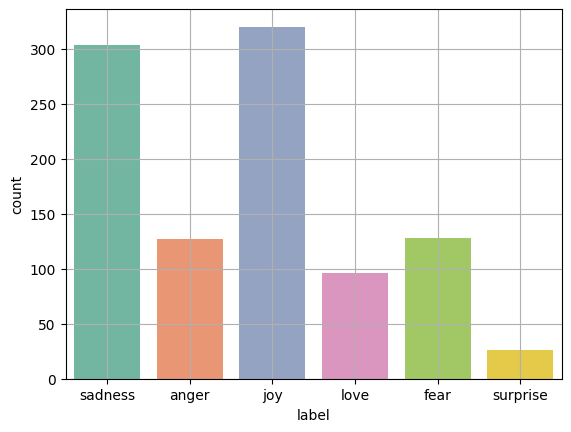

In [11]:
sns.countplot(x='label', data = data, palette='Set2')
plt.grid()
plt.show()

* label 에 대한 정수 인코딩

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])
data.head()

,text,label
0,i feel the melancholy running my veins as well,4
1,im feeling cranky im very defensive about it,0
2,i should feel blessed to have but what about m...,2
3,i do know is this i have no desire to spend my...,4
4,im feeling awfully spiteful right now,0


### (4) GPU 설정
* 파이토치를 위한 설정

In [13]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2.데이터 준비

### (1) Dataset 만들기 : train, val

In [14]:
train, val = train_test_split(data, test_size=0.2, random_state=42)

In [15]:
# 텐서 데이터셋
train_ds = Dataset.from_pandas(train)
val_ds = Dataset.from_pandas(val)

In [16]:
train_ds[:3]

{'text': ['i am feeling so nostalgic lately i would like to say it is because i am yearning for a simpler time but those times i find myself thinking of are far from simple',
  'i feel more relaxed now that i will get good care and that i need to accept advice given to me unless i feel very strongly otherwise',
  'i have to visit them every after school and later i have to go tuition and i do not have the time to even study for my exam next week and i have a feeling that i am so going to fail a lot of my subjects and to be blamed for either not concentrating during class or not studying'],
 'label': [3, 2, 4],
 '__index_level_0__': [29, 535, 695]}

### (2) 토큰화

In [17]:
# 모델과 토크나이저 불러오기
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [18]:
# 토큰화 함수 생성 및 작업
def preprocess_function(data):
    return tokenizer(data['text'], truncation=True, padding=True)

train_ds = train_ds.map(preprocess_function, batched=True)
val_ds = val_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

## 3.Fine-Tuning

### (1) 사전학습 모델 준비

In [19]:
# 모델 설정 (다중 분류를 위해 num_labels 지정)
n = 6
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = n).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### (2) 학습

* TrainingArguments 설정
    * Hugging Face의 transformers 라이브러리에서 모델 학습에 필요한 다양한 설정을 지정하는데 사용

* 각 설정에 대한 설명
    * **output_dir = './results'**  
        * 모델 학습의 출력물(모델, 로그 파일 등)을 저장할 디렉토리
    * **eval_strategy = "epoch"**
        * 매 에폭이 끝날 때마다 평가. 평가에는 검증(validation) 데이터를 사용하여 모델의 성능을 측정
    * **save_strategy = "epoch"**  
        * 체크포인트를 언제 저장할지 결정.
        * "epoch" : 각 에폭이 끝날 때마다 체크포인트 저장
        * 체크포인트는 나중에 중단된 지점에서 학습을 재개할 수 있도록 모델의 상태를 저장
    * **weight_decay = 0.01**
        * 과적합 방지 규제(regularization) 기법 중 하나.
        * 모델의 가중치가 학습 중에 감소하는 비율
        * 일반적으로 작은 값(0.01)이 설정됩니다.
    * **logging_dir = './logs'**
        * 학습 중 로그 파일 저장 디렉토리
        * 학습 중에 성능 지표를 기록하여 시각화하거나 분석하는 데 사용
    * **report_to = "tensorboard"**
        * TensorBoard : 손실, 정확도 등 모델의 성능 지표를 그래프로 볼 수 있는 도구
        * TensorBoard로 로그를 전송하여 학습 진행 상황을 시각화할 수 있도록 설정

In [20]:
training_args = TrainingArguments(
    output_dir = './results',          # 출력 디렉토리
    eval_strategy = "epoch",            # 에폭마다 평가
    save_strategy = "epoch",           # 에폭마다 체크포인트 저장
    learning_rate = 2e-5,              # <--[조정가능]학습률
    per_device_train_batch_size = 32,  # <--[조정가능]학습 배치 사이즈
    per_device_eval_batch_size = 32,   # <--[조정가능]평가 배치 사이즈
    num_train_epochs  = 5,              # <--[조정가능]에폭 수
    weight_decay = 0.02,               # <--[조정가능]weight decay
    load_best_model_at_end = True,     # 가장 좋은 모델을 마지막에 로드
    logging_dir ='./logs',            # 로깅 디렉토리
    logging_steps = 10,                # 로깅 스텝
    report_to="tensorboard"          # TensorBoard에 로깅
)

* Trainer
    * Hugging Face의 transformers 라이브러리에서 제공하는 고수준 API로, 모델 학습과 평가를 쉽게 할 수 있도록 도와주는 클래스

In [21]:
# Trainer 설정
trainer = Trainer(
    model=model,                         # 학습할 모델
    args=training_args,                  # TrainingArguments
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)], # 조기 종료
)

In [22]:
# 모델 학습
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.630400,1.539107
2,1.393900,1.331675
3,1.234100,1.144921
4,1.031600,1.064041
5,0.977200,1.035564


TrainOutput(global_step=125, training_loss=1.29289892578125, metrics={'train_runtime': 58.6409, 'train_samples_per_second': 68.212, 'train_steps_per_second': 2.132, 'total_flos': 74518227072000.0, 'train_loss': 1.29289892578125, 'epoch': 5.0})

In [23]:
# 모델 평가
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 1.0355637073516846, 'eval_runtime': 0.4151, 'eval_samples_per_second': 481.852, 'eval_steps_per_second': 16.865, 'epoch': 5.0}


### (3) 모델 사용

In [25]:
text = "I'm absolutely thrilled with the way everything turned out!"
predicted_class, probabilities = predict(text, model, tokenizer)

print(f"예측된 클래스: {predicted_class}")
print(f"예측된 클래스 이름: {le.inverse_transform([predicted_class])}")
print(f"클래스별 확률: {probabilities}")

예측된 클래스: 2
예측된 클래스 이름: ['joy']
클래스별 확률: tensor([[0.0654, 0.0481, 0.6816, 0.0996, 0.0463, 0.0591]], device='cuda:0')


### (4) 모델 검증평가

In [28]:
pred, prob = evaluate(val_ds, model, device, tokenizer)

In [29]:
print(confusion_matrix(val_ds['label'], pred))
print(classification_report(val_ds['label'], pred, target_names = le.classes_))

[[ 1  1  1  0 19  0]
 [ 2  3  3  0 23  0]
 [ 0  0 54  0  4  0]
 [ 0  0 17  0  3  0]
 [ 0  0  4  0 62  0]
 [ 0  0  2  0  1  0]]
              precision    recall  f1-score   support

       anger       0.33      0.05      0.08        22
        fear       0.75      0.10      0.17        31
         joy       0.67      0.93      0.78        58
        love       0.00      0.00      0.00        20
     sadness       0.55      0.94      0.70        66
    surprise       0.00      0.00      0.00         3

    accuracy                           0.60       200
   macro avg       0.38      0.34      0.29       200
weighted avg       0.53      0.60      0.49       200

